<a href="https://colab.research.google.com/github/gcorani/bda/blob/main/3_Bayesian_hypthotesis_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()

from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
sns.set(rc={'figure.figsize':(7,3)})
np.random.seed(44)


# Bayesian Hypothesis Testing for comparing two groups

Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``

> Notebook inspired to https://www.pymc.io/projects/examples/en/latest/case_studies/BEST.html

# Shortcomings of the frequentist tests


### They cannot verify $H_0$

* The *weak* decision of not rejecting $H_0$ does not imply that $H_0$ has high probability of being true. The frequentist test cannot verify $H_0$.

* Instead, being able to verify $H_0$ we could e.g.:

  * discover that two classifiers have practically the same accuracy and thus choose the one which is easier to deploy.
  
  * discover that two drugs are equally effective and choose the one with less side-effects.


### The tested hypothesis are too sharp

* If the optimal length for a piece we produce is 5mm, our hypothesis is
\begin{align*}
H_0:\quad & \mu = 5\\
H_1:\quad & \mu \neq 5
\end{align*}

* If our production is working with a mean of $5+\epsilon$, the test will reject $H_0$ (if the sample size is large enough), because $H_0$ is  false.
Yet, our production is practically well calibrated.

* We need a way to set $H_0$ so that it includes an interval of values around 5, for which we think the production to be well calibrated. This is done in Bayesian testing by using the rope (region of practical equivalence).

### Traditional hypothesis test do not include expert knowledge

* They do not represent expert knowledge,  as they consider only information from the sample.
  




# Bayesian tests

* Allows representing domain knowledge in the prior (prior sensitivity checks are recommended).

* Compute the posterior probability of $H_0$ and $H_1$.


# Region of practical equivalence (rope)
      
* To compute the posterior probability of $H_0$  we define a region of practical equivalence (rope) on  parameter being tested.

* For instance we could consider the accuracies of two classifiers practically  equivalent if their difference is in  $\pm 0.01$; accuracy  ranges in $(0, 1)$.

* We then compute check the posterior probability of the difference of accuracy lying within the rope.

* If the posterior probability of $H_0$ is large, we actually accept $H_0$.

* The rope is chosen subjectively and  reflects the knowledge of the analyst. Sensivity to the choice of the rope can be also carried out.


# Drug trial evaluation

* We  want to  evaluate  of a drug that is supposed to increase intelligence.

* We have IQ measures  of:
    * 47 individuals receiving the drug  (treatment group)
    * 42 individuals  receiving the placebo (control group).
    

* The sample mean of the drug group  is superior, but:

    * there is a lot of variability within groups
    * there are some outliers
    * the variability of the drug group is larger than that of the placebo group

In [2]:
#GC data

iq_drug = np.array ([101,100,102,104,105,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,104,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,103,103,100,101,103,104,100,101])


iq_placebo = np.array ([ 99,101,100,101,99,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
                         101,100,99,101,100,102,99,98,99])



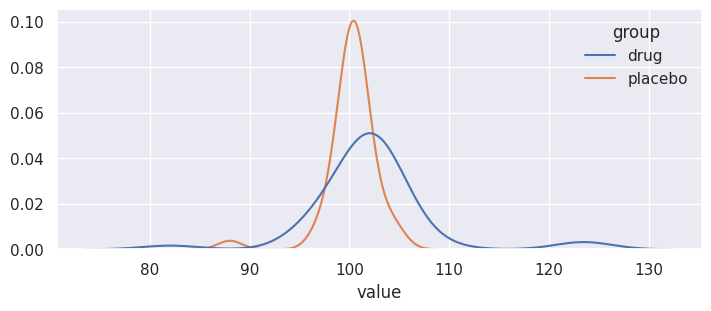

In [3]:
y  = pd.DataFrame(dict(value=np.r_[iq_drug, iq_placebo], group=np.r_[['drug']*len(iq_drug), ['placebo']*len(iq_placebo)]))
sns.kdeplot(data=y, x="value", hue="group")
plt.ylabel('');

# Notation

* Samples statistics:

    * the sample means $\bar{x}_1$ and $\bar{x}_2$

    * the sample standard deviations $s_1$ $s_2$

    * the sample size $n_1$ and $n_2$


* Recall that $\bar{x}_1$ is the empirical mean observed on the sample, while $\mu_1$ is the unknown mean of the population from which the sample has been taken.



* The sample are drawn from two populations with unknown parameters $\mu_1, \mu_2, \sigma_1, \sigma_2$.

* In the following, we use the subscript `drug` and `placebo` to clarify to which group we refer.

# Research questions

* We will make inference (compute the posterior density of) about $\mu_{\text{drug}} - \mu_{\text{placebo}}$.


## Are the two means *statistically* different?
Test the sharp hypothesis $\mu_{\text{drug}} - \mu_{\text{placebo}} = 0$

  * frequentist answer: two-tailed test

  * Bayesian answer: check whether the HDI of $\mu_{\text{drug}} - \mu_{\text{placebo}}$ includes 0.

* This question might be relevant if you want to compare the production of the same item between two different plants.


## Does the drug have a *statistically* positive effect?

This is a more appropriate question for assessing the effect of the drug
  * frequentist answer: one-tailed test
  * Bayesian answer: posterior probability of $\mu_{\text{drug}} - \mu_{\text{placebo}} > 0$

Sometimes however there is statistical significance, but the difference has no practical relevance.

## Which is the probability of the difference being *practically* significant?
This is  the most useful question to answer.

  * frequentist answer: N/A

  * Bayesian answer:  define the rope and compute the posterior probability of $\mu_{\text{drug}} - \mu_{\text{placebo}}$ being at the right of the rope.

  * The probability of $\mu_{\text{drug}} - \mu_{\text{placebo}}$  belonging to the rope is instead the probability of the drug being practically equivalent to the placebo.




# Frequentist approach: one-tailed t-test for two samples
We want to demonstrate that the drug is effective:


\begin{align*}
H_0: \; & \mu_{\text{drug}} \leq \mu_{\text{placebo}} \\
H_1: \; & \mu_{\text{drug}} > \mu_{\text{placebo}}
\end{align*}

Statistic of the two-sample test:

\begin{align*}
t = \frac{\bar{x}_1 - \bar{x}_2} { \sqrt{S_p^2 \left( \frac{1}{n_1} + \frac{1}{n_2} \right)} }
\end{align*}

with the *pooled variance* being:

\begin{align*}
S_p^2 = \frac{(n_1-1)  s_1^2 + (n_2-1) s_2^2}{(n_1 -1)  + (n_2 - 1)}
\end{align*}

Assumptions:
* the observations are independent
* the two populations have the same variance ($\sigma_1^2=\sigma_2^2$)
* the sample is large enough (e.g., $n_1, n_2 > 10$) to guarantee that the sample mean is normally distributed (central limit theorem)

* This is a one-tailed $t$-test, whose critical value is the quantile ($1-\alpha$) of the $t$ distribution with (42 + 47 - 2) degrees of freedom.


In [4]:
import scipy.stats as stats

x_bar_drug    = np.mean(iq_drug)
x_bar_placebo = np.mean(iq_placebo)
var_drug      = np.var(iq_drug)
var_placebo   = np.var(iq_placebo)

n_drug    = len(iq_drug)
n_placebo = len(iq_placebo)

weighted_sum_var = ( (n_drug - 1) * var_drug + (n_placebo -1 ) * var_placebo)
var_pooled =  weighted_sum_var / ( n_drug - 1 + n_placebo -1)
std_err =  np.sqrt( var_pooled * (1/n_drug + 1/n_placebo))

# statistic
t = (x_bar_drug - x_bar_placebo) / std_err

print("t statistic: ", np.round(t,2))

#t distribution with (n_drug + n_placebo - 2 ) degrees of freedom
critical = stats.t.ppf(0.95, df= n_drug + n_placebo - 2)
print("critical value: ", np.round(critical,2))
#the test does not reject the null.
#We cannot rule out that the drug is as effective as the placebo.

t statistic:  1.92
critical value:  1.66


## Conclusion of the frequentist test

* We reject the null hypothesis;  the positive effect of the drug is *statistically significant*.

# Bayesian approach: recall the normal-normal model

* We fit a normal-normal model on each group.


* Then we study the posterior distribution of the difference ($\mu_1 - \mu_2$)


* Recall the normal-normal model:
\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu}) \\
\sigma &  \sim \text{half-normal}(\xi) \\
y & \sim N(\mu, \sigma) \\
\end{align*}


# Prior information

* According to the <a href="https://www.123test.com/interpretation-of-an-iq-score/"> IQ scale meaning </a>.

    * the mean IQ of the population is in (80, 120).
    * extreme values of IQ  are 60 ( cognitively impaired) and 140 (gifted).
    


# Prior for $\mu_{\text{drug}}$ and $\mu_{\text{placebo}}$

* The  mean IQ of the population  lies in (80, 120);  we interpret this as an interval of $\pm 2 \sigma$ around the mean. Thus:

$$
\mu_{\text{drug}}   \sim  N (100, 10 )
$$
$$
\mu_{\text{placebo}}   \sim  N (100, 10 )
$$

* We assign the same priors to both groups, so that we are not favoring a group over another a priori.



# The prior $p(\sigma)$ is halfnormal

* To tune the prior of $\sigma$, we tune the scale $\xi$ of the halfnormal.
  * A smaller $\xi$ concentrates the prior density near zero, while a larger $\xi$ spreads it out more.
  * $\xi$ is the standard deviation of the parent normal distribution, from which we sample discarding the negative samples.
  * In pymc, $\xi$ is referred to as the `sigma` of the `halfnorm`.




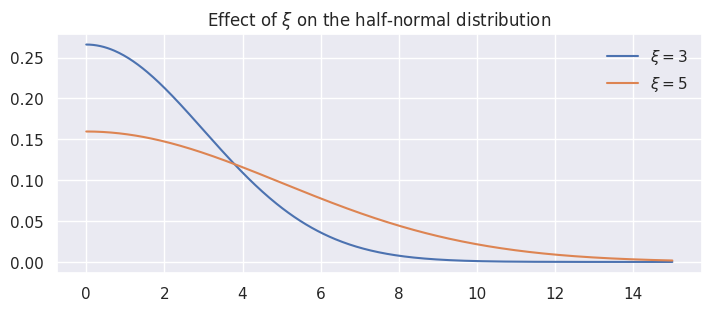

In [5]:
from scipy.stats import halfnorm
# Compute PDF for half-normal distributions with scale=1 and scale=3
x = np.linspace(0, 15, 500)
y3 = halfnorm.pdf(x, scale=3)
y5 = halfnorm.pdf(x, scale=5)

sns.lineplot(x=x, y=y3, label=r'$\xi = 3$')
sns.lineplot(x=x, y=y5, label=r'$\xi = 5$')

plt.title(r'Effect of $\xi$ on the half-normal distribution')
plt.legend();

# Tuning $p(\sigma)$ via prior predictive check

* When we set priors for more than one parameter, we need also to check how the prior of the different parameters interact.

* In previous lectures we tuned $\xi$ by matching the median of the halfnormal with a plausible value of $\sigma$.

* In this example it might be more effective to tune it with a prior predictive check: we simulate virtual data from the prior and  check that the range of the simulated values of IQ is sensible.

* We generate 5000 virtual observations $y^{\text{rep}}$, where `rep` stand for *virtual replicates* as:

\begin{align*}
\mu &\sim N(100, 10)\\
\sigma &\sim HN(\xi)\\
y^{\text{rep}} &\sim N(\mu, sigma)
\end{align*}

We tune $\xi$ by checking the range of  $y^{\text{rep}}$. This allows checking that the prior on $\sigma$ interacts sensibly with the prior on $\mu$.

## First attempt: $\xi = 30$

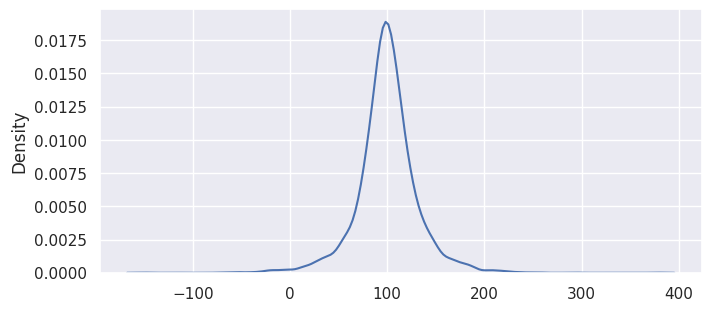

In [6]:
def sim_y_ref(xi):
  from scipy.stats import norm
  from scipy.stats import halfnorm
  n = 5000

  #draws plausible mean from the prior
  mean =  stats.norm.rvs(loc=100, scale=10,  size = n)

  #draws plausible sigmas from the prior
  sigma = stats.halfnorm.rvs(scale=xi, size = n)

  #draws plausible IQ, given a draw of mu and sigma
  y_rep = norm.rvs(mean, sigma)
  return(y_rep)

y_rep30 = sim_y_ref(30)
sns.kdeplot(y_rep30);

* The simulated data include unrealistic large and impossible negative values.

* We need reducing  $\xi$.

* By trial and error,  we generate data on a realistic range setting $\xi=8$.

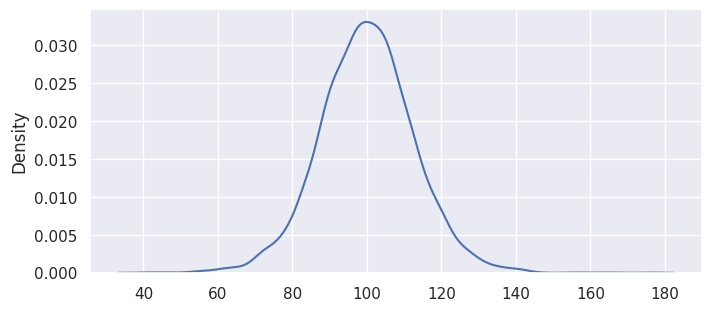

In [7]:
# this seems like a good choice.
y_rep8 = sim_y_ref(8)
sns.kdeplot(y_rep8);

# Your turn: prior predictive check

* Tune the halformal prior of $\sigma$ for the model of the distribution of height of adult males in Switzerland

* A priori, we assume the mean height of the population to be 175, and to possibly lie in the interval 165 - 185. This provides the prior on $\mu$.

* Extreme values of height in the population are  100 and 250.

Using the prior predictive check, tune $\xi$ of the model:
\begin{align*}
\mu \sim N(175, 5)\\
\sigma \sim HN(\xi)
\end{align*}

* Solution at the end of the notebook.


# Back to hypothesis testing

## Likelihood

* Assuming a Gaussian distribution of the observations:

$$\vec{y}_{drug} \sim N(\mu_{\text{drug}}, \sigma_{\text{drug}})$$

$$\vec{y}_{placebo} \sim N(\mu_{\text{placebo}}, \sigma_{\text{placebo}})$$

where  the vector notation shows that these are array of measures.



# The probabilistic model

* Looking at the data, it seems more appropriate to have a different $\sigma$ parameter for each population: the drug are much more spread than the placebo ones.


\begin{align*}
\mu_{\text{drug}} & \sim N(100,10) \\
\sigma_{\text{drug}} & \sim \text{half-normal} (8) \\
\vec{y}_{\text{drug}}  & \sim N(\mu_{\text{drug}}, \sigma_{\text{drug}}) \\
\\
\mu_{\text{placebo}} & \sim N(100,10) \\
\sigma_{\text{placebo}} & \sim \text{half-normal} (8) \\
\vec{y}_{\text{placebo}}  & \sim N(\mu_{\text{placebo}}, \sigma_{\text{placebo}})\\
\\
\delta_{\mu} &= \mu_{\text{drug}} - \mu_{\text{placebo}}
\end{align*}


* $\delta_{\mu}$ is the difference of the two means.

* For each sample of $\mu_{\text{drug}}$ and $\mu_{\text{placebo}}$, the trace will also include a sample of their difference $\delta_{\mu}$.

* This is a *deterministic* parameter in PyMC (it is a deterministic function of other parameters).


In [8]:

with pm.Model() as  normal_model:
    #prior on the means
    mu_drug         = pm.Normal     ('mu_drug',  mu = 100,  sigma = 10)
    mu_placebo      = pm.Normal     ('mu_placebo', mu = 100,  sigma = 10)

    # priors on the two sigmas
    # the xi of the halfnormal distribution is the sigma which is argument of the halformal
    sigma_drug      = pm.HalfNormal ('sigma_drug',  sigma=8)
    sigma_placebo   = pm.HalfNormal ('sigma_placebo', sigma=8)


    #likelihood of group 1
    y_drug = pm.Normal  ('y_1', mu=mu_drug, sigma=sigma_drug, observed= iq_drug)

    #likelihood of group 2
    y_placebo = pm.Normal  ('y_2',  mu=mu_placebo, sigma=sigma_placebo, observed= iq_placebo)

    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means = pm.Deterministic ('diff_of_means', mu_drug - mu_placebo)


In [9]:
with normal_model:
    # GC: to use 1 core is needed to run on my laptop.
    normal_trace   = pm.sample(chains=4, cores=1)

Output()

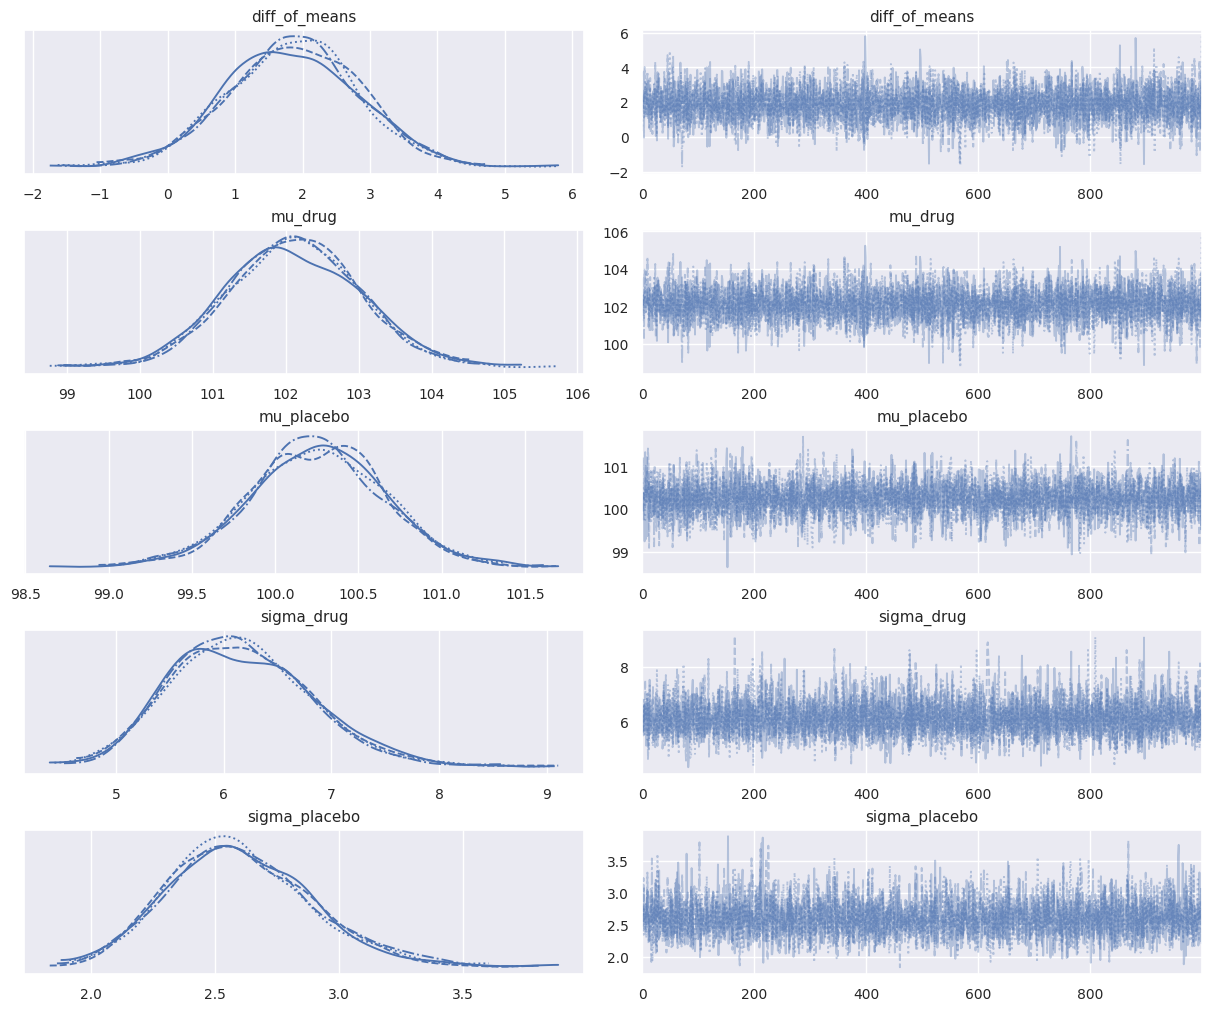

In [10]:
#sampling was good.

az.plot_trace(normal_trace);

# There is a statistically significant difference between $\mu_{\text{drug}}$ and $\mu_{\text{placebo}}$?



In [11]:

# We check if 0 is contained in the 95% HDI.
# As the 0 is included in the HDI, though it is close to the lower bound, we cannot rule out that the effect is 0.
az.summary(normal_trace, hdi_prob=0.95)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
diff_of_means,1.857,0.979,0.091,3.898,0.013,0.016,5783.0,3184.0,1.0
mu_drug,102.109,0.899,100.370,103.842,0.012,0.014,5513.0,2945.0,1.0
mu_placebo,100.252,0.400,99.484,101.065,0.005,0.006,5588.0,3055.0,1.0
sigma_drug,6.165,0.663,4.925,7.443,0.009,0.011,5882.0,3366.0,1.0
sigma_placebo,2.605,0.291,2.050,3.171,0.004,0.005,5180.0,2933.0,1.0


## Probability of a positive effect

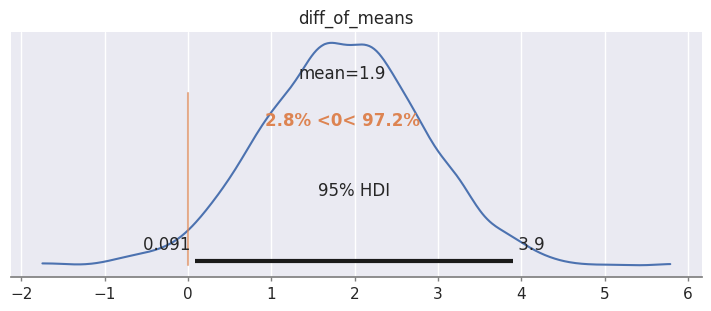

In [12]:

# This is the counterpart of the one-tailed test.
# There is about 97%  probability of the effect being positive; thus we accept the hypothesis of a positive effect.
# This is a more relevant question than the previous one to assess the drug.
az.plot_posterior(normal_trace,  var_names="diff_of_means", ref_val=0, hdi_prob=0.95);

# Probability of being  practically equivalent to / pratically better than placebo

---



---



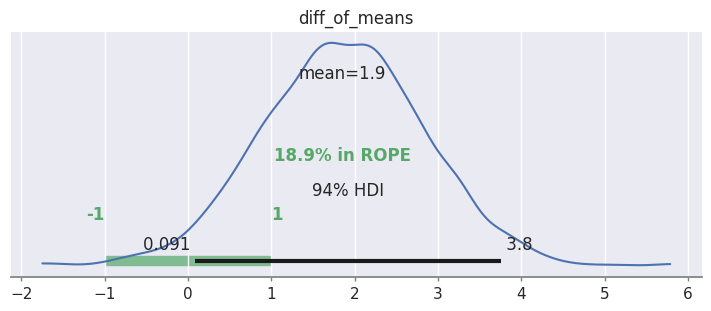

In [13]:
# We assume the two mean to be practically equivalent if their difference is in the rope (-1, +1).
# The probability of the difference between the means to be in the rope is around 18%.
# That is, there is 18% probability of the effect of the drug being practically equivalent to a placebo.
# This type of analysis is not possible in frequentist tests.
az.plot_posterior(normal_trace,  var_names="diff_of_means", rope=[-1,1]);

In [14]:
#To compute the probability of having a positive effect which is practically relevant,
# we compute the probability of the difference between the means lying at the right of the rope.
# We need to access the samples of the trace.
# The answer is more nuanced compared to traditional test (we do not have 95% probability) but also more informative
# as it considers also  the size of the effect.

samples                  = az.extract(normal_trace)
diff_samples             = samples.diff_of_means.values
p_significant_positive   = (diff_samples > 1).sum() / len(diff_samples)
p_significant_negative   = (diff_samples < -1).sum() / len(diff_samples)
p_practically_eq         = 1 - p_significant_negative - p_significant_positive

print("p_significant_positive: ", "%.3f" % p_significant_positive)
print("p_practically_eq: ", "%.3f" % p_practically_eq)
print("p_significant_negative: ", "%.3f" % p_significant_negative)

p_significant_positive:  0.809
p_practically_eq:  0.189
p_significant_negative:  0.003


# Wait a moment. Is the model appropriate? Make a posterior predictive check!

Before running pymc....
* Quiz yourself: write a pseudo code for the posterior predictive check of the above model

Output()

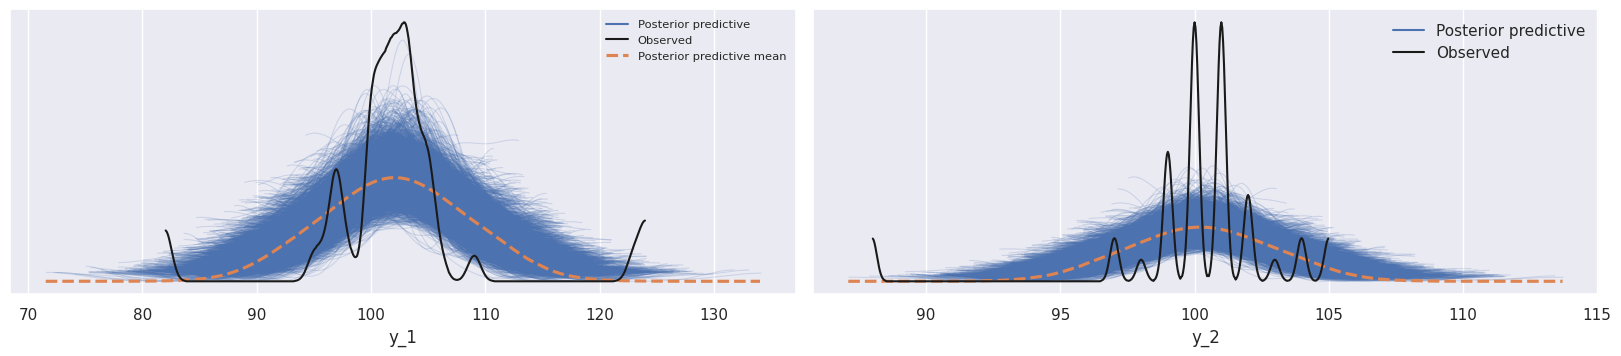

In [15]:

with normal_model:
     ppc = pm.sample_posterior_predictive(normal_trace)

# The density is too low in the bulk of the distribution, for both groups.
az.plot_ppc(ppc);

## Robust likelihood

* The density is too low in the center of the distribution.


* We now adopt as likelihood function a Student-t distribution with 4 degrees of freedom to better deal with outliers

$$y_{\text{drug},i} \sim t(\mu_{\text{drug}}, \sigma_{\text{drug}}, \nu=4)$$

$$y_{\text{placebo},i} \sim t(\mu_{\text{placebo}}, \sigma_{\text{placebo}},  \nu=4)$$


In [16]:
with pm.Model() as student_model:
    #prior are  unchanged.
    mu_drug_t         = pm.Normal     ('mu_drug_t',     mu = 100,  sigma = 5)
    mu_placebo_t      = pm.Normal     ('mu_placebo_t',   mu = 100,  sigma = 5)
    sigma_drug_t      = pm.HalfNormal ('sigma_drug_t',  sigma=8)
    sigma_placebo_t   = pm.HalfNormal ('sigma_placebo_t', sigma=8)

    #robust likelihood.
    y_drug    = pm.StudentT ('y_drug',nu=4, mu=mu_drug_t, sigma=sigma_drug_t, observed= iq_drug)
    y_placebo = pm.StudentT ('y_placebo', nu=4, mu=mu_placebo_t, sigma=sigma_placebo_t, observed= iq_placebo)


    diff_of_means_t = pm.Deterministic('diff_of_means', mu_drug_t - mu_placebo_t)
    robust_trace   = pm.sample()

Output()

Output()

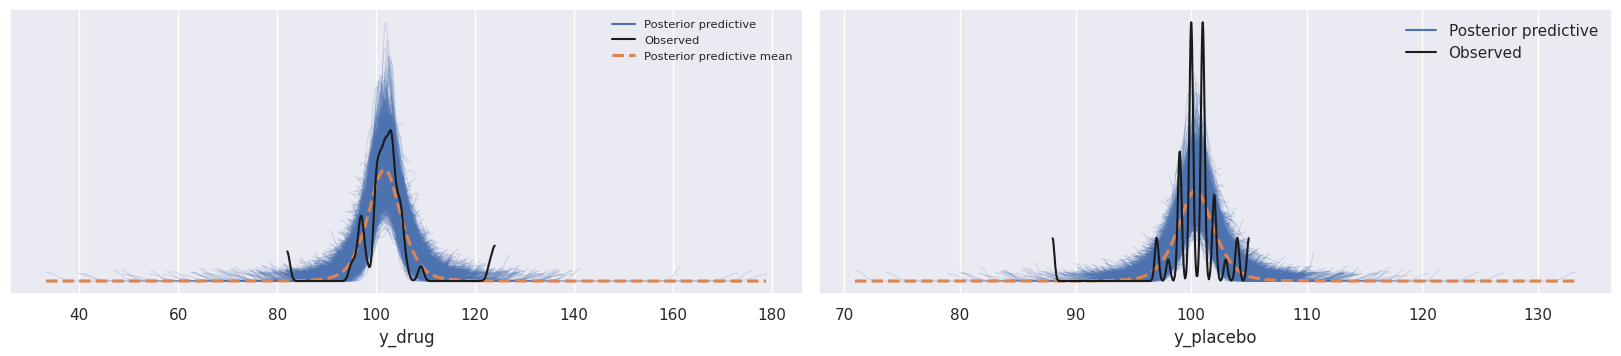

In [17]:
#the fit is better compare to the normal model, though not yet perfect for the placebo group.
with student_model:
    ppc_t = pm.sample_posterior_predictive(robust_trace)
    az.plot_ppc(ppc_t);

In [18]:
# the robust model (on top of the table) provides a clearer estimate of the effect.


df = pd.concat( [az.summary(robust_trace,  hdi_prob=0.95), az.summary(normal_trace, hdi_prob=0.95) ])

# here we filter the data frame to only see the diff_of_means
# in the table below, the first line refers to the robust model, the second to the normal model
# the HDI is much shorter (more informative) with the robust model.
# Moreover, it also becomes all positive.
df.iloc[[0,5]]


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
diff_of_means,1.371,0.551,0.326,2.475,0.010,0.012,3292.0,1755.0,1.0
diff_of_means,1.857,0.979,0.091,3.898,0.013,0.016,5783.0,3184.0,1.0


# Analysis of the posterior of the robust model

## Are the means statistically different?

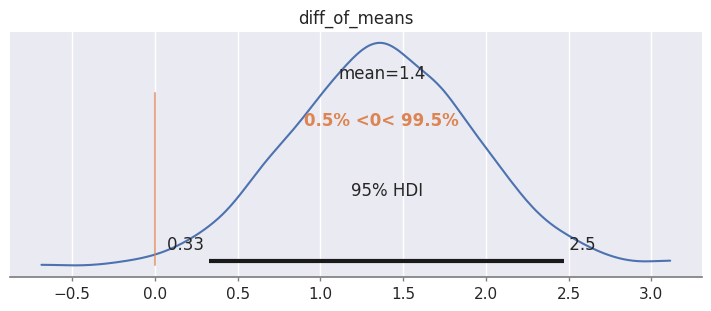

In [19]:
# 0 is no longer within the HDI; it is no longer a plausible value.
# The robust model rejects the hypothesis of the two populations having the same mean.

az.plot_posterior(robust_trace, var_names=['diff_of_means'],  ref_val=0, hdi_prob=0.95);

## Probability of the  means being practically equivalent

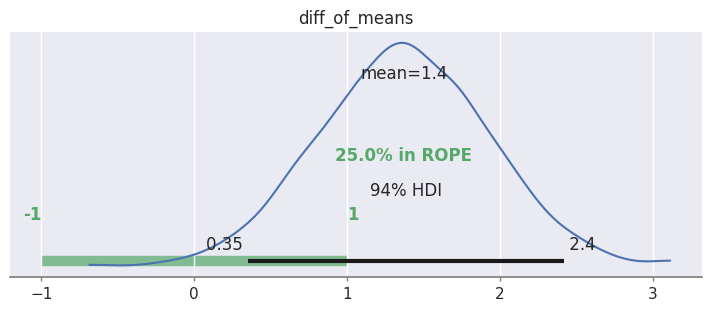

In [20]:
az.plot_posterior(robust_trace, var_names=['diff_of_means'], rope=[-1,1]);

In [21]:
#Posterior probability of the positive effect being practically positive, practically negative or practically equivalent,
#according to the robust model.

student_samples             = az.extract(robust_trace)
diff_samples                = student_samples.diff_of_means.values
p_significant_positive      = (diff_samples > 1).sum() / len(diff_samples)
p_significant_negative      = (diff_samples < -1).sum() / len(diff_samples)
p_practically_eq            = 1-  p_significant_negative  -  p_significant_positive

print("p_significant_positive: ", "%.3f" % p_significant_positive)
print("p_practically_eq: ", "%.3f" % p_practically_eq)
print("p_significant_negative: ", "%.3f" % p_significant_negative)

p_significant_positive:  0.750
p_practically_eq:  0.250
p_significant_negative:  0.000


# Discussion

* The  analysis of the posterior density of $\mu_1 - \mu_2$ allows taking informative conclusions about the effectiveness of the drug.

* There is 99% probability of the drug having a *positive* effect ($P(\delta)>0$).

* If we introduce the rope, we have a more informative outcome:
  * the effect is positive but practically irrelevant with probability ~.25
  * the effect is positive and practically relevant with probability ~.75

* The conclusions based on the rope are more informative than the simple probability of the effect being positive.

* You can repeat the analysis with different ropes, as the choice of the rope is subjective.


# An example of test where prior information is important

# Comparing two proportions: does sex ratio depend on beauty?

A study on some American couples shows that:

* The proportion of girls among the children of "attractive” parents is 56% (𝑋 = 168, 𝑛 = 300).

* The proportion of girls among the children of “standard” parents is 48% (𝑋 = 1296, 𝑛 = 2700).

If the difference statistically significant?

>  From: *Regression and Other Stories, Gelman et al., Sec. 9.5, 2022*

# Hypothesis test

\begin{align*}
H_0 &: \pi_{\text{attr}} ≤ \pi_{\text{std}}\\
H_1 &: \pi_{\text{attr}} > \pi_{\text{std}}
\end{align*}

* $\pi_{\text{attr}}$: proportion of girls in "attractive" couples
* $\pi_{\text{std}}$: proportion of girls in "standard" couples

# Frequentist analysis


\begin{align*}
Z &= \frac{p_{attr} - p_{std}} { \sqrt{\bar{p} (1 - \bar{p})  
(\frac{1}{n_1} + \frac{1}{n_2}} )} = 2.63
\end{align*}

* $p_{attr}$: proportion of girls in the sample of the attractive couples

* $p_{std}$: proportion of girls in the sample of the standard couples

* $ \displaystyle \bar{p} = \frac{n_{std} p_{std} + p_{attr} n_{attr}} {n_{std}+n_{attr}}$

* With $\alpha=0.01$, the critical value is the quantile 0.99 of the $N(0,1)$, namely $2.33$.

* The statistic exceed the critical value.

* The null hypothesis is rejected; the proportion of girls in the two groups is significantly different.


* The standard error (denominator) is aroud 0.03.


# Prior for the Bayesian hypothesis test

* The variation in the human sex ratio occurs in a very narrow range.

* The percentage of girl births, which is known  to vary between 48.4% and 49% (Regression and Other Stories, Gelman et al., Sec. 9.5, 2022).

* Differences of half of a percentage point (or less) have been found when comparing based on factors such as birth order, maternal age, or season of birth.

* We thus try to have a Beta prior whose 95% interval is about (48.4%, 49%). This is indeed representing strong prior knowledge.


# Tune the beta prior for girl ratio

* Consider the prior Beta($\alpha,\beta$)

* We set its expected value to 0.487, which implies:

\begin{align*}
\frac{\alpha}{\alpha + \beta} &= .487 \\
\beta &\approx 1.05 \alpha
\end{align*}


* After some trial and error (see code below) we settle for:
\begin{align*}
\alpha &= 5000 \\
\beta &= 1.05 \cdot 5000 = 5250
\end{align*}

In [22]:
from scipy.stats import beta

# here are some attempts
c = 1.05 #multiplicative constant

a = 10
beta.interval(confidence = 0.95, a = a, b = c*a)
# 0.27 - 0.68: too large

a = 100
beta.interval(confidence = 0.95, a = a, b = c*a)
# 0.41 - 0.55: still too large

a = 200
beta.interval(confidence = 0.95, a = a, b = c*a)
# 0.43 - 0.53: still too large.
# The intervals changes very little as we increase a.

a = 5000
i = beta.interval(confidence = 0.95, a = a, b = c*a)
print(np.round(i,2))
# 0.478 0.497: it does not match exactly our prior beliefs, but it is close enough.
# Notice that our prior sample size (5000 + 1.05 * 5000 = 5000 + 5250 = 10250) is larger than the sample size of the study.

[0.48 0.5 ]


# Tune the Beta prior

* The choice $\alpha$ and $\beta$ shows that we have strong prior knowledge.

* In the conjugate interpretation of the beta-binomial priors,  this prior is equivalent to having more than 10000 virtual samples.


# Beta-binomial model of the two groups and the the difference between the two $\theta$

\begin{align*}
\theta_{\text{attr}} &\sim \text{Beta}(5000, 5250)\\
X_{\text{attr}} &\sim \text{Binom}(y =1296, n=2700, p=\theta_{\text{attr}})\\
\\
\theta_{\text{std}} &\sim \text{Beta}(5000, 5250)\\
X_{\text{std}} &\sim \text{Binom}(y=168, n=300, p=\theta_{\text{std}})\\
\\
\delta \theta &= \theta_{\text{attr}} - \theta_{\text{std}}
\end{align*}



# Posterior of the two groups

Since the model is conjugate, the posteriors are:



\begin{align*}
\alpha_{\text{std}} &= 5000 + 1296 = 6296 \\
\beta_{\text{std}} &= 5250 + 2700 - 1296 = 6654\\
\theta_{\text{std}} &\sim \text{Beta}(6296, 6654)\\
\\
\alpha_{\text{attr}} &= 5000 + 168 = 5168 \\
\beta_{\text{attr}} &= 5250 + 132 = 5382\\
\theta_{\text{attr}} &\sim \text{Beta}(5168, 5382)
\end{align*}


* We do not need probabilistic programming as we already analitically have the posterior of the two groups. In general we need instead to use prob programming (as in the previous example about drug effect).

* In the second group the prior knowledge is stronger than the knowledge extracted from the data.


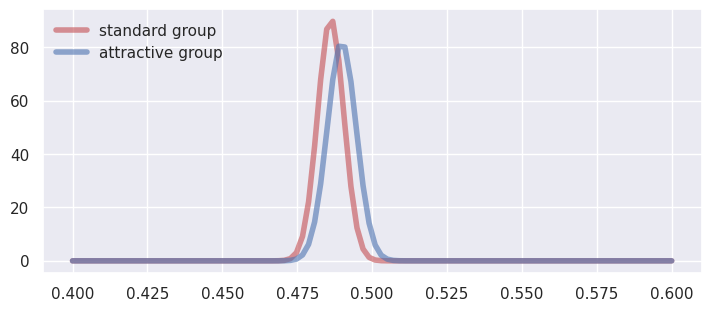

In [23]:
#Visualize two posteriors distribution of theta for the two groups.
# I constrain the limits of the plot between .4 and .6
x = np.linspace(0.4, 0.6, 100)
plt.plot(x, beta.pdf(x, a=6296, b=6654), 'r-', lw=4, alpha=0.6, label='standard group')
plt.plot(x, beta.pdf(x, a=5168, b=5382), 'b-', lw=4, alpha=0.6, label='attractive group')
plt.legend(loc="upper left");

# Is the posterior difference between the two groups significant?

* We have the posterior betas of the two groups, which are independent.

* We  obtain the distribution of the posterior difference by sampling independently from the two groups and then creating a sample of differences.

* Recalling that we know that the percentage of girl births varies between 0.484 and 0.49, we consider a rope of $\pm 0.002$.





In [24]:
# Is the difference between the proportion in the two groups significantly different from 0?
#samples from the first group, the second group and samples of the difference
post_standard = beta.rvs(a=6296, b=6654, size=10000)
post_attractive = beta.rvs(a=5168, b=5382, size=10000)
post_diff =  post_attractive - post_standard

#half interval of the rope
half_rope = 0.002

# prob of a practically higher girl rate for attractive parents
print("prob of the positive difference to be practical: ", np.round(np.mean(post_diff > half_rope),2))

# prob of a practically equivalente girl rate between the two groups
count_in_rope = np.sum((post_diff >= -1 * half_rope) & (post_diff < half_rope))
prob_rope = count_in_rope / len(post_diff)
print("prob of the rate being practically equivalent in the two groups: ", np.round(prob_rope,2))


# prob of a practically equivalente girl rate between the two groups
count_left_rope = np.sum((post_diff < -1 * half_rope))
prob_left_rope = count_left_rope / len(post_diff)
print("prob of the rate being practically smaller in the two attractive group: ", np.round(prob_left_rope,2))

prob of the positive difference to be practical:  0.6
prob of the rate being practically equivalent in the two groups:  0.2
prob of the rate being practically smaller in the two attractive group:  0.2


# Discussion

* Overall we have only weak evidence: the birth rate of girls has some 60% probability of being practically higher among attractive parents than standard parents. It is a 40% probability of being practically equivalent or smaller. This a much cautious conclusion than that of the frequentist test.

* The prior is in this case fundamental to achieve a sensible conclusion.

* Given the strong weight of the prior, it is however recommended to ask different experts, elicit a different prior and rope and repeat the analysis (prior sensitivity).



* In the following we do an extreme prior sensitivity check, assuming no prior information (i.e., uniform prior).


# Re-analysis with flat prior (no prior information)

* If we use a Beta(1,1) prior:

\begin{align*}
\alpha_{\text{std}} &= 1 + 1296 = 1297 \\
\beta_{\text{std}} &= 1 + 1404 = 1495\\
\theta_{\text{std}} &\sim \text{Beta}(1297, 1405)\\
\\
\alpha_{\text{attr}} &= 1 + 168 = 169 \\
\beta_{\text{attr}} &= 1 + 132 = 133 \\
\theta_{\text{attr}} &\sim \text{Beta}(968, 932)
\end{align*}


In [25]:
#samples from the first group, the second group and samples of the difference
post_standard_beta11 = beta.rvs(a=1297, b=1495, size=10000)
post_attractive_beta11 = beta.rvs(a=169, b=133, size=10000)
post_diff_beta11 = post_attractive_beta11 -  post_standard_beta11

# a lot of uncertainty in the posterior interval if we have no prior knowledge
q=np.quantile(post_diff_beta11, q=[.025, .975])
print("Analysis without rope:")
print("95% posterior interval of the difference: ", q)

Analysis without rope:
95% posterior interval of the difference:  [0.03656321 0.15273049]


# Discussion

* Generally, Bayesian analysis with uniform prior yields conclusions which are similar to that of the frequetist test.

* In this example, a uniform prior on sex gender is not tenable.


# Conclusions

* If we had no prior knowledge, the outcome of the test would be consistent with the frequentist test (declaring significance of the differences).

* However a flat prior on gender ratio is not tenable, as we have substantive knowledge.

* Generally defining a rope and report the posterior probability of $\delta \theta$ belonging to the rope, falling into its left and its right is more valuable than simply checking the probability of the difference being positive.

> Kruschke, John K. "Bayesian estimation supersedes the t test." Journal of Experimental Psychology: General 142.2 (2013): 573.

# Exercises

# Posterior distribution of functions of the parameters:  effect size

An indicator used to  compare the means of the two populations is *effect size* (Cohen's $d$):

$$
\displaystyle
\frac{\mu_2 - \mu_1}{\sigma_P}$$

where  $\sigma_P$ is the pooled standard deviation,  $\sigma_P = \sqrt{ \frac{\sigma_2^2 + \sigma_1^2}{2} }$

* Effect size is  the amount of change induced by the treatment relative to the standard deviation. It is often used in medical studies.



* Once we have the posterior samples of $\mu_1, \mu_2, \sigma$ we can computer the posterior distribution of other indicators, which are deterministic functions of them.

# Exercise 1

* In the drug example, compute the posterior probability of the effect size being:

    * negative ($d < 0$)

    * positive small ($0 \leq d \leq 0.3$)

    * positive, medium strenght  ($0.3 \leq d \leq 0.8$)

    * positive, large ($d >  0.8$)



* Hints:

    * define `effect_size` as a deterministic variable of the model.

    * use `extract_dataset` to access the samples of the trace.

# Exercise 2: comparing death rates between different treatments

* An experiment was performed to estimate the effect of beta-blockers on mortality of cardiac patients, which in general is comprised between 1% (0.01) and 9% (0.09).


* Out of 674 patients of the control group (placebo) 39 died;  out of 680 receiving the treatment, 22 died.


* A difference in death rates within the interval $\pm$0.005 is considered  to have no practical consequence.

* Draw your conclusions by analyzing the posterior distribution of the difference between the  death rates in the two groups.

# Hints

* Tune the parameters of the  beta prior by checking the limits of the 95% HDI interval; see the interval method of [the beta distribution in scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html)


* The syntax for the binomial likelihood in pymc is `pm.Binomial('variable_name', n=number of trials, p = theta, observed= number of successes)`

# Solutions

## Prior predictive check for male height

In [26]:
# simulate data of male height
# it is  the same code for prior predictive check for IQ, with a different prior on the mean
def sim_y_ref_height(xi):
  from scipy.stats import norm
  from scipy.stats import halfnorm
  n = 5000

  #draws plausible mean from the prior
  mean =  stats.norm.rvs(loc=175, scale=5,  size = n)

  #draws plausible sigmas from the prior
  sigma = stats.halfnorm.rvs(scale=xi, size = n)

  y_rep = norm.rvs(mean, sigma)
  return(y_rep)

# as first attempt we set \xi = 15, but the distribution is too large
height_rep15 = sim_y_ref_height(15)
pd.DataFrame(height_rep15).describe()

,0
count,5000.000000
mean,175.277005
std,15.776716
min,74.799928
25%,168.177166
50%,175.174004
75%,182.423520
max,289.325300


#

In [27]:
# With \xi=9 the predictive check is ok.
# If you want to be more precise, you can check numerically the extremes of the simulated data
height_rep9 = sim_y_ref_height(9)
pd.DataFrame(height_rep9).describe()

,0
count,5000.000000
mean,174.825361
std,10.261571
min,112.151425
25%,169.365542
50%,174.968465
75%,180.312136
max,224.716226


## Pseudo-check: posterior predictive check for the model fitted on the IQ data


* We compute the  predictive distribution, to be later compared with the density of the data. The trace is as follows:

$$
\left[
\begin{array}{llll}
\mu_{\text{drug,1}} &   \sigma_{\text{drug,1}} &
\mu_{\text{placebo,1}} &   \sigma_{\text{placebo,1}}
\\
\mu_{\text{drug,2}} & \sigma_{\text{drug,2}} &
\mu_{\text{placebo,2}} &   \sigma_{\text{placebo,2}}
\\
\vdots & \vdots  \\
\mu_{\text{drug,4000}}  & \sigma_{\text{drug,4000}} &
\mu_{\text{placebo,4000}} &   \sigma_{\text{placebo,4000}}
\\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{ll}
y^{\text{new}}_{\text{drug,1}} & y^{\text{new}}_{\text{placebo,1}}\\
y^{\text{new}}_{\text{drug,2}} & y^{\text{new}}_{\text{placebo,2}}\\
\vdots \\
y^{\text{new}}_{\text{drug,4000}} & y^{\text{new}}_{\text{placebo,4000}}\\
\end{array}
\right]
$$

For each sample $s$ ($s$=1,2... 4000) we generate a data set as large as the original one. Namely we sample:

* 47 observations from $y^{\text{new}}_{\text{drug,s}} \; \sim \; N\left(\mu_{\text{drugs,s}}, \sigma_{\text{drugs,s}} \right)$
  
* 42 observations from $y^{\text{new}}_{\text{placebo,s}} \; \sim \; N\left(\mu_{\text{placebo,s}}, \sigma_{\text{placebo,s}} \right)$

* The two groups (drug and placebo) are independent.

* We thus first perform the predictive check for the drug. We show the kde of each simulated data set for the drug and we compare with the density of the real drug data.

* Then we do the same for the placebo.
   


* The  4,000 drawn values of $y_{\text{new}}$ are the *predictive* distribution of a new measurement.

# Posterior distributon of the effect size

In [28]:
#computing the effect size as a deterministic variable within the student model.

with pm.Model() as student_model_effect:
    #prior are  unchanged.
    mu_drug_t           = pm.Normal     ('mu_drug_t',       mu = 100,  sigma = 5)
    mu_placebo_t        = pm.Normal     ('mu_placebo_t',    mu = 100,  sigma = 5)
    sigma_drug_t        = pm.HalfNormal ('sigma_drug_t',    sigma=25)
    sigma_placebo_t     = pm.HalfNormal ('sigma_placebo_t', sigma=25)

    y_drug = pm.StudentT ('y_drug',       nu=4, mu=mu_drug_t,  sigma=sigma_drug_t,       observed= iq_drug)
    y_placebo = pm.StudentT ('y_placebo', nu=4, mu=mu_placebo_t, sigma=sigma_placebo_t, observed= iq_placebo)

    #Effect size as a deterministic variable.
    effect_size  = pm.Deterministic('effect_size', (mu_drug_t - mu_placebo_t) / (  (sigma_drug_t**2 + sigma_placebo_t**2) /2 )**(1/2))
    student_trace_effect    = pm.sample(return_inferencedata=True)

Output()

In [29]:
#Posterior probability of the effect size being negative, or positive  (disaggregated as small, medium and large).
samples                  = az.extract_dataset(student_trace_effect)
effect_samples      = samples.effect_size.values

# count the samples in which the effect size negative
p_negative             = ( ( (effect_samples<0).sum() ) /  len (effect_samples) )

#a slightly more complex syntax is necessary to count the sample within a given range
p_small                   =  np.logical_and(effect_samples > 0,  effect_samples < 0.3)
p_small                   =  p_small.sum() / len (effect_samples)

p_medium             =  np.logical_and(effect_samples > 0.3,  effect_samples < 0.8)
p_medium             =  p_medium.sum() / len (effect_samples)

p_large                   = ( ( (effect_samples>0.8).sum() ) /  len (effect_samples) )

print("p effect size is negative: ", "%.3f" % p_negative)
print("p effect size is small: ", "%.3f" % p_small)
print("p effect size is medium: ", "%.3f" % p_medium)
print("p effect size is large: ", "%.3f" % p_large)

#check the computed probs sum up to 1
print ("sum: ", p_large + p_medium + p_small + p_negative)

p effect size is negative:  0.009
p effect size is small:  0.106
p effect size is medium:  0.683
p effect size is large:  0.203
sum:  1.0


/tmp/ipython-input-3515733997.py:2: FutureWarning: extract_dataset has been deprecated, please use extract
  samples                  = az.extract_dataset(student_trace_effect)


# Comparing the death rates between two beta blockers

# First, we need tuning the Beta prior

* We know that the mortality rate is between 0.01 and 0.09; the median point of the interval is 0.05.

* We thus set the expected value of the beta such that $\alpha$/($\alpha + \beta$) = 0.05.
  
* Hence, $\alpha$ = $\beta$ * 0.05 / 0.95.

* For instance for $\beta$=100, we get $\alpha = 100 * 0.05 / 0.95 = 5.2$ (which I round to 5 for simplicity)


In [37]:
import scipy.stats as stats
b =  100
a =  5
random_var = stats.beta(a,b)
interval_95 = random_var.interval(confidence=0.95)

#this interval is already satisfactory, as it well represents our prior information.
#no further tuning required
print(np.round(interval_95,3)) #[0.016 0.096]

[0.016 0.096]


In [38]:
# Analysis of the mortality using the beta-binomial model
# We could equivalently compute the posterior betas and the difference between their samples.
# A Beta(5,100) has expected value 0.05, and most of its mass below 0.1. This represents  appropriately our prior information.

with pm.Model() as binomial_diff:
    theta_treatment = pm.Beta('theta_treatment', alpha=5, beta=100)
    theta_control   = pm.Beta('theta_control', alpha=5, beta=100)

    #we need to write the model using the binomial likelihood
    dead_treatment = pm.Binomial ('dead_treatment ',  p=theta_treatment, observed=22, n=680)
    dead_control   = pm.Binomial ('dead_control ',    p=theta_control, observed=39, n=674)

    #Difference between the two mortality rates is a deterministic variable.
    diff_theta      = pm.Deterministic('diff_theta', theta_treatment - theta_control)
    binomial_trace  = pm.sample(return_inferencedata=True)

Output()

In [32]:
#The binomial trace also contains samples for diff_theta
az.summary(binomial_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
diff_theta,-0.022,0.011,-0.042,-0.003,0.0,0.0,1926.0,1358.0,1.0
theta_control,0.056,0.009,0.041,0.073,0.0,0.0,1990.0,1219.0,1.0
theta_treatment,0.035,0.006,0.022,0.046,0.0,0.0,2077.0,1453.0,1.0


# Analysis with rope

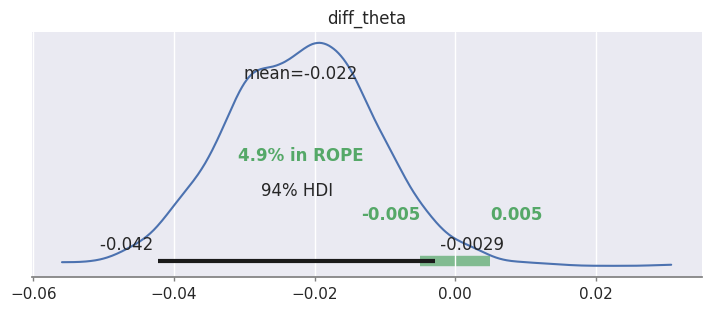

In [33]:
# Most density on the difference of theta is on the theta values at the left of the rope, implying
# a practically significant reduction of mortality due to the drug.
# There is about only 5% probability of the treatment being practically equivalent to to the placebo.
az.plot_posterior(binomial_trace, var_names='diff_theta', rope= [-0.005, 0.005]);


In [34]:
#Compute the probability by which diff_theta is at right, left and within the rope.
binomial_samples            = az.extract(binomial_trace)
diff_samples                = binomial_samples.diff_theta.values
p_significant_increase      = (diff_samples > 0.005).sum()  / len(diff_samples)
p_significant_decrease      = (diff_samples < -0.005).sum() / len(diff_samples)
p_practically_eq            = 1-  p_significant_increase  -  p_significant_decrease

print("p (drug significantly increase the death rate): ", "%.3f" % p_significant_increase)
print("p_practically_eq: ", "%.3f" % p_practically_eq)
print("p_significant_decrease: ", "%.3f" % p_significant_decrease)

p (drug significantly increase the death rate):  0.005
p_practically_eq:  0.049
p_significant_decrease:  0.946


## Conclusion
* There is strong evidence in favor of the treatment, which has about 95% probability of being practically effective.
